In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
artists_df = pd.read_json('data/data_v2/artists.jsonl')
sessions_df = pd.read_json('data/data_v2/sessions.jsonl')
tracks_df = pd.read_json('data/data_v2/tracks.jsonl')
users_df = pd.read_json('data/data_v2/users.jsonl')

In [ ]:
artists_df.isnull().sum()

In [ ]:
sessions_df.isnull().sum()

In [ ]:
tracks_df.isnull().sum()

In [ ]:
users_df.isnull().sum()

In [ ]:
sessions_df.dropna(inplace=True)

In [ ]:
artists_df.info()

In [ ]:
sessions_df.info()

In [ ]:
tracks_df.info()

In [ ]:
users_df.info()

In [ ]:
artists_df.shape

In [ ]:
sessions_df.shape

In [ ]:
tracks_df.shape

In [ ]:
users_df.shape

In [ ]:
artists_df.head(10)

In [ ]:
sessions_df.head(10)

In [ ]:
tracks_df.head(10)

In [ ]:
users_df.head(10)

Poniżej zamieściłem wykresy z 50 najpopularniejszymi gatunkami wśród artystów i użytkowników.

In [ ]:
popular_genres_artists = (artists_df.explode("genres")
                            ).value_counts("genres")[:50].iloc[::-1]

popular_genres_artists.plot(kind="barh",
                            title ="Most popular artists genres",
                            xlabel="Popularity",
                            ylabel="Genre",
                            figsize=(10,15))

In [ ]:
popular_genres_users = (users_df.explode("favourite_genres")
                          ).value_counts("favourite_genres")[:50].iloc[::-1]

popular_genres_users.plot(kind="barh",
                          title="Most popular users genres",
                          xlabel="Popularity",
                          ylabel="Genre", 
                          figsize=(10,15))

Mapa korelacji pomiędzy wybranymi atrybutami dla utworów.

In [ ]:
df = tracks_df[[
    "popularity","duration_ms", "explicit",
    "danceability", "energy", "key", 
    "loudness", "speechiness", "acousticness", 
    "instrumentalness", "liveness" , "valence", 
    "tempo"]]

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

Wykres kołowy przedstawiający procent użytkowników premium.

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
users_df["premium_user"].value_counts().plot(kind="pie", 
                                             title="User account type",
                                             ax = ax,
                                             labels=None,
                                             autopct='%1.1f%%',
                                             )

ax.legend(loc=3, labels=["Standard", "Premium"])
plt.show()

Wykres przedstawiający 30 najczęściej pojawiających się utworów w sesjach.

In [ ]:
track_popularity = sessions_df[
    sessions_df["event_type"] == "play"
  ].value_counts("track_id").rename_axis('id').reset_index(name='counts')

track_popularity = track_popularity.merge(tracks_df, 
                       left_on="id", 
                       right_on="id")[["name", "counts"]][:30].iloc[::-1]

track_popularity.plot(kind="barh",
                        x = "name",
                        y = "counts",
                        title="Most popular track from sessions",
                        xlabel="Popularity",
                        ylabel="Title", 
                        figsize=(10,15))

Wykres słupkowy dla utworów powstałych w danym roku.

<Axes: ylabel='year'>

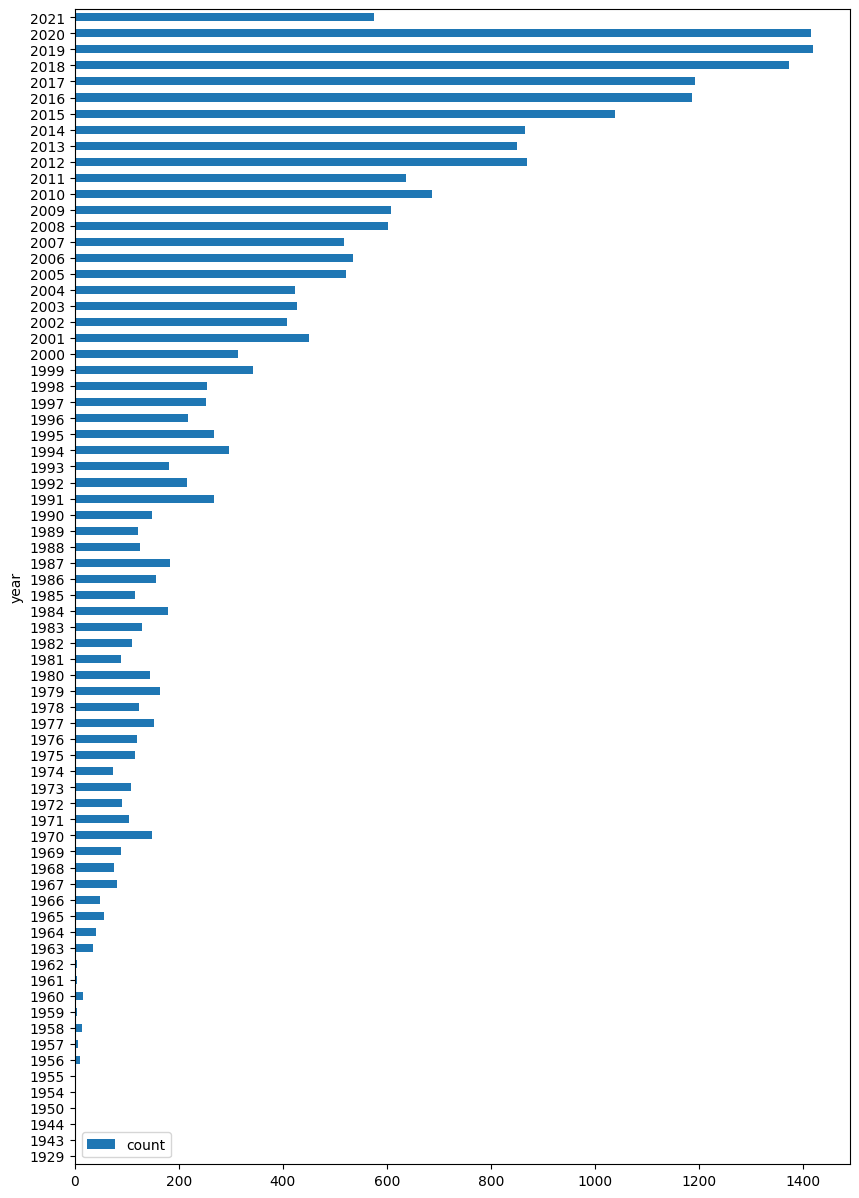

In [88]:
series = tracks_df["release_date"].map(lambda x: x[:4]).astype({"release_date" : int}).value_counts()
df = pd.DataFrame()
df["year"] = series.index
df["count"] = series.values

df.sort_values(by=["year"]).plot(
    x="year",
    y="count",
    kind="barh",
    figsize=(10,15)
)

In [ ]:
df = pd.merge(sessions_df.mask(sessions_df.eq('None')), tracks_df.mask(tracks_df.eq('None')), how='inner', left_on = 'track_id', right_on = 'id')

In [ ]:
df = pd.merge(sessions_df.mask(sessions_df.eq('None')).dropna(), tracks_df.mask(tracks_df.eq('None')).dropna(), how='inner', left_on = 'track_id', right_on = 'id')

In [ ]:
df.head(10)

In [ ]:
user_track = pd.merge(sessions_df.mask(sessions_df.eq('None')), tracks_df.mask(tracks_df.eq('None')), how='inner', left_on = 'track_id', right_on = 'id')
user_track = pd.merge(user_track, users_df, how='inner', left_on = 'user_id', right_on = 'user_id')
user_track.drop(["session_id","user_id","id","track_id","id_artist","street"],axis=1,inplace=True)
user_track.rename(columns={"name_x": "track_name", "name_y": "user_name"}, inplace=True)

In [ ]:
user_track